# Microscopy model for Nemaktis

## 1. General description

In a real transmission and/or reflection microscope, objects are imaged using a combination of lighting systems and lenses. The path of light in such microscopes can always be decomposed in three steps:

1. Light propagates from the illuminating source to the object through the illumination optical setup.
2. Light is transmitted through (or reflected from) the object.
3. Light transmitted or reflected from the object propagates through the microscope objective and form an observable image in a target plane.

The case of spectrally-extended lighting (e.g. white light lamp) can be easily covered by summing-by-intensity the final images formed by the different wavelengths of the lamp spectrum (in Nemaktis, this is done internally after repeating the imaging simulations for all the wavelengths in a user-defined array approximating the lamp spectrum). Here, we consider for simplicity's sake a simple microscopy model based on lighting with a single wavelength. We describe below the physical mechanisms behind the three steps introduced above. 

## 2. Koehler illumination setup

The first propagation step is the illumination of the object by the light source. The standard illumination setup used in most microscopes is called the Koehler illumination setup (introduced by August Koehler in 1893), and has the advantage of allowing a uniform lighting even with non-uniform light source. In short, it allows to map each point of the light source to a single uniform plane wave incident on the object with a certain angle; the maximum angle of incidence for the plane waves is set by an aperture called the **condenser aperture**, thus the set of plane waves incident on the object all have wavevectors included inside a cone of illumination whose opening is set by the condenser aperture. In addition, a **field aperture** allows to control the size of the lighting spot on the object, but this feature is irrelevant in Nemaktis since we always assume that the whole computational box representing the object is illuminated.

In order to better understand how this illumination setup works, an interactive example is provided below. The reader can run this example by clicking inside the code cell below and pressing Shift+Enter, and then can dynamically adjust the sliders for opening/closing the field and condenser apertures.

<IPython.core.display.Javascript object>


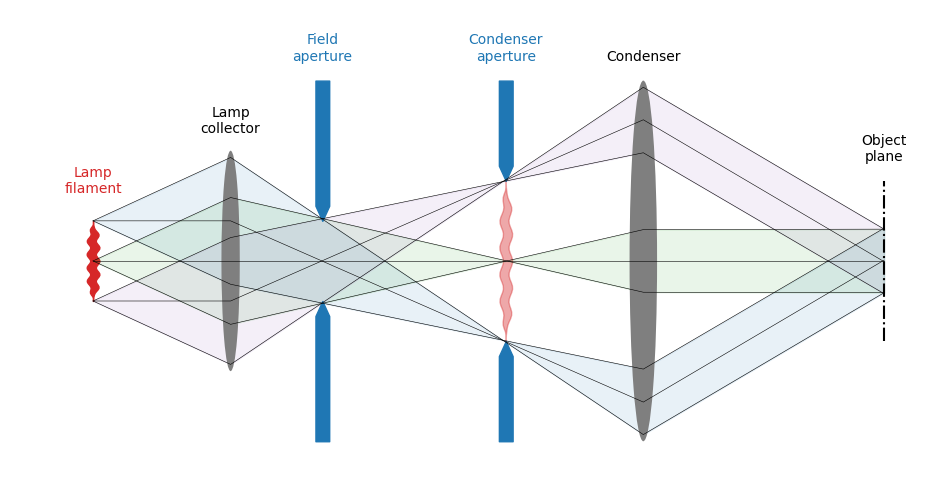

interactive(children=(FloatSlider(value=1.0, description='Condenser Aperture Opening:', layout=Layout(width='5…

In [5]:
from koehler import *
from ipywidgets import interact, FloatSlider, Layout

%matplotlib notebook

koehler_setup = draw_koehler_setup(figsize=(9.5,5))
opts = {"style":{'description_width':'initial'},"layout":Layout(width='50%'),"value":1,"min":0,"max":1,"step":0.05}
slider1 = FloatSlider(description='Condenser Aperture Opening:', **opts)
slider2 = FloatSlider(description='Field Aperture Opening:', **opts)
interact(koehler_setup.update, cond_ap_opening=slider1, field_ap_opening=slider2);

A correctly assembled Koehler illumination setup has the following properties:
- The field aperture is in the back focal plane of the lamp collector lens.
- The condenser aperture is in the front focal plane of the condenser lens.
- The image of the lamp filament through the lamp collector lens is in the same plane as the condenser aperture.
- The image of the field aperture throught the condenser lens is is in the same plane as the object.

We emphasize that the lamp filament is always spatially incoherent, thus the different incident plane waves cannot interfer between themselves. This means that the final image in the microscope is always obtained by summing-by-intensity the individual images formed by each incident plane waves. In real life, there is always an infinite number of plane waves incident on the object, but in the computer one must choose an approximate discrete set of plane waves. In Nemaktis, the set of incoming plane waves is chosen to have the following wavevectors (assuming that the third coordinate correspond to the main propagation axis in the microscope):

$$\vec{k}^{(k,l)}=k_0\left(\begin{align}
    q^{(k)} \cos\theta^{(k,l)} \\ q^{(k)} \sin\theta^{(k,l)} \\ \sqrt{1-\left[q^{(k)}\right]^2}
\end{align}\right)$$

where we defined $k_0=2\pi/\lambda$ with $\lambda$ the wavelength in empty space and:

$$\begin{align}
    q^{(k)} &= \frac{k}{N_r-1}\mathrm{NA}_\mathrm{max},\quad\quad k=0\cdot\cdot\cdot N_r-1 \\
    \theta^{(k,l)} &= \frac{\pi l}{3k},\quad\quad\quad\quad\quad\quad l=0\cdot\cdot\cdot 6k
\end{align}$$

Here, $\mathrm{NA}_\mathrm{max}=\sin\psi_\mathrm{max}$ (with $\psi_\mathrm{max}$ the maximal angle of opening of the wavevectors) is the maximal numerical aperture of the Koehler illumination setup, and $N_r$ correspond to the number of discretization steps in the radial direction. This choice of wavevectors correspond to a standard discretization of a circular aperture in the transverse plane, which looks like this when $N_r=5$:

<img src="images/mesh.png" />

In Nematkis, this mesh is fully characterized by the two parameters, $\mathrm{NA}_\mathrm{max}$ and $N_r$, and has a total number of points of $1+3N_r(N_r-1)$. Since this mesh is (weakly) nonuniform, we use a tailored integration rule to recombine the microscope images in the final imaging plane, which also have the benefit of being able to dynamically change the numerical aperture of the condenser between $0$ and $\mathrm{NA}_\mathrm{max}$ in the microscope's user interface.

To conclude this section, we mention the final approximation made in Nemaktis for the illumination setup: we assume that all the incoming plane waves have the same intensity. This approximation is probably not true in a real microscope, but has the advantage of always yielding rotationally invariant images when observing rotationally invariant objects (e.g. isotropic droplets), as empirically observed in most microscopes. In any case, the goal of our simple model of Koehler illumination setup for Nematkis is only to provide a qualitatively correct description of the "smoothing" effect (due to the increasing number of incident planewaves) of a real microscope when opening the condenser aperture.

## 3. Transmission/Reflection of light inside the object

The next step is the transmission or reflection of light inside the object. In Nemaktis, we exlude metallic surfaces and metamaterials, and assume that the object is fully transparent (no absorption), time-invariant (no fluctuations leading to light scattering), and can be represented by a permittivity tensor field $\epsilon_{ij}(x,y,z)$ which is discretized on a 3D cartesian mesh. The transmission and reflection of light in such objects is modeled by the well-known wave equation for the time-harmonic Maxwell electric field $\vec{E}(x,y,z)\exp\left[-ik_0ct\right]$ (with $c$ the light speed and $k_0$ the wavevector in empty space):

$$\vec\nabla\times\vec\nabla\times\vec{E}-k_0^2\bar{\bar\epsilon}\vec{E}=0$$

There exists general schemes for fully solving this equation (most notably the Finite-Difference-Time-Domain method), but they are computationally very intensive, which is why we resort to less expansive (but approximate) methods in Nemaktis. More specifically, we propose three "backends" which allows to propagate the optical fields inside the object and are described in the following subsections. As a general rule, each backend provides a set of mappings between each incoming plane waves (see Sec.&nbsp;2) and output optical fields (in the current version of Nemaktis, only transmitted optical fields are considered as "output").

### 3.1 The beam-propagation backend (bpm-solver)

This backend comes from a subset of a generalized framework for beam propagation in general birefringent medium that I developed (see citation below). This generalized framework relies on a minimal set of physical assumptions (most notably a relatively small refractive index contrast $\Delta n<0.4$ inside the object) and admits two Beam Propagation Methods (BPM):

- Wide-angle BPM, which can accurately propagate optical fields up to deviation angles of 20-30°.
- Paraxial BPM, which can accurately propagate optical fields up to deviation angles of 5-10°. 

The second version of BPM is especially suite for microscopy applications, since in most microscopes (exluding confocal microscopes with high numerical aperture objective) only the paraxial components of light contributes to the final image. In our open-source package Nemaktis, only paraxial BPM is included as a backend for microscopy, but we are open to new collaborations on our closed-source wide-angle BPM for advanced use (nonlinear optics, modeling of complex photonics devices, steering of light using birefringent structures...).

At its core, the beam propagation works by decomposing the optical (electric) field $\vec{E}$ in forward and backward propagating fields inside a series of layers approximating the full permittivity profile $\bar{\bar\epsilon}(x,y,z)$:

<img src="images/layers.svg" width="400" height="200" />

The permittivity tensor is assumed to be stepwise constant along $z$ (the main axis of propagation inside the microscope) but is allowed to have arbitrary variations in the transverse directions $x$ and $y$. Our beam propagation framework correspond to a set of equations allowing to propagate the optical fields inside each layers (including diffraction and beam walk-off effects due to the nonuniformity of the optical and permittivity fields) and transfer fields through the discontinuity interface between each layer. In Nemaktis, we assume smooth variations of the permittivity along $z$ and therefore only propagates forward-propagating fields using the following formula:

$$\mathbf{E}(z_{n+1})=\mathbf{U}\cdot\mathbf{E}(z_n),$$

where $\mathbf{E}(z_n)$ is a huge vector containing all degree-of-freedoms for the optical fields in the transverse plane $z=z_n$ and $\mathbf{U}$ is an evolution operator which can be written as an easy-to-compute product of exponential of sparse matrices representing differential operators on 2D meshes. The evolution operator $\mathbf{U}$ is directly derived from Maxwell equations with a few mathematical assumptions (small index contrast and paraxiality of fields) and can be applied in a very efficient way (complexity $O(N)$, with $N$ the total number of degree-of-freedoms for the computational mesh).

Since we only take into account forward-propagating fields, reflection microscopy is currently not supported in Nemaktis, but we hope to implement this feature in the future since we already derived the associated theoretical framework. Note that internally, each imaging simulation includes a lot of different paraxial BPM sub-simulation for each incident plane-wave, source wavelength, and input polarisations. Using the same notation as in Sec.&nbsp;2 and assuming a single input wavelength, the incident optical fields for all these sub-simulations are written as:

$$\vec{E}^{(k,l,m)}(x,y)=\exp\left\{i\left[x k^{(k,l)}_x+y k^{(k,l)}_y\right]\right\}\vec{u}_m,$$

where $k$ and $l$ are the indices for the input wavevector $\vec{k}^{(k,l)}$ and $\vec{u}_m$ ($m=1,2$) is an orthogonal basis for the input polarisation. The use of repeated simulations based on orthogonal polarisations allows efficient imaging simulations of arbitrary polarized optical micrographs (using polariser, analyzer, waveplate...), with a dynamic adjustment of the associated parameters (e.g. polariser and analyzer angle) in the graphical user interface.

Readers interested in our beam propagation framework can read the associated publication:

<a href="https://doi.org/10.1364/OE.400984">[G. Poy and S. Žumer, Optics Express 28, 24327 (2020)]</a>


### 3.2 The diffraction transfer matrix backend (dtmm)

This backend correspond to a python package originally written by a colleague, Dr. Andrej Petelin, and that we decided to include in Nemaktis for easy comparison between different approaches of electromagnetic field propagation. At its core, the diffractive transfer matrix method (DTMM) of Dr. Petelin is conceptually very close to the beam propagation backend presented above in Sec.&nbsp;3.1: the permittivity tensor field representing the object is also split in a series of birefringent slabs, evolution operators are similarly used to propagate the fields inside the slabs, and continuity equations are used to transfer the fields between the layers. The difference between DTMM and our BPM framework mainly lie in the way that the evolution operators are calculated: in DTMM, this evolution operator is calculated with a clever heuristic combination of the Berreman method and diffraction transfer matrix applied in Fourier space. The Berreman method was originally developped for the calculation of transmitted and reflected light in layered system (permittivity tensor field independent from $x$ and $y$) and neglects diffraction (the redistribution of optical energy due to non-uniformity of the optical and permittivity fields); in DTMM, the evolution operators derived by Berreman are combined with a powerful treatment of diffraction in Fourier space based on local mode grouping, thus allowing to take into account variations of fields in the $x$ and $y$ directions.

Since this is a Fourier-based method, its complexity is $O(N\log\left[N/N_z\right])$ with $N$ the total number of mesh points and $N_z$ the number of layers. It is also based on a user-defined parameter allowing to define the accuracy of diffraction in the simulation: low value of this parameter provide quick (but inacurate) simulations with faster running times than BPM on relatively small meshes (for big meshes, the logarithmic complexity of dtmm kicks in and DTMM is slower than BPM), whereas high value provide accurate simulations (computational errors slightly worse than the ones obtained with BPM, but still relatively good) with slower running times than with BPM. 
In short, DTMM is the perfect backend if you want to quickly try imaging simulations without worrying too much about the accuracy, whereas BPM is more suited for efficient accurate simulations on arbitrary big meshes (provided that enough random-access-memory is available!).

In Nemaktis, DTMM is closely integrated in the high-level python package allowing to run imaging simulations, but we emphasize that DTMM also has a dedicated python package with advanced features such as iterative algorithms for the calculation of reflected fields (a feature which is currently missing in the BPM backend):

<a href="https://github.com/IJSComplexMatter/dtmm">[DTMM: a Diffractive Transfer Matrix Method]</a>


### 3.3 The ray-tracing backend (rt-solver)

This backend relies on the so-called geometrical optics approximation and works by decomposing the incoming plane wave in a series of light rays, which are propagated through the object using Hamiltonian ray-tracing equations. The validity of this method is quite restricted: the permittivity tensor field $\bar{\bar\epsilon}(x,y,z)$ must correspond to a uniaxial birefringent medium whose optical axis is smoothly varying in space, with typical variation lengths much bigger than the wavelength of light. It also necessitates some tweaking in order to correctly reconstruct the optical fields on a cartesian mesh (since the ray-tracing method only gives optical fields along rays, which can be deflected by the object).

<img src="images/rt_method.svg" width="400" height="200" />

Since this method cannot be really used as a "blackbox" simulation tool, it is provided as such (i.e. as a low-level C++ code) without any integration in the easy-to-use high-level python interface in Nemaktis. Nevertheless, this method can still be useful to get some physics insight on how light is deflected in particular systems (see for example  <a href="https://journals.aps.org/prx/accepted/e7079K21E0b1aa0f05f42018ad497a7ce5be190ce">[J. Hess, G. Poy, J.-S. B. Tai, S. Žumer and I. I. Smalyukh, Phys. Rev. X (2020)]</a> or to make attractive scientific visualizations like the image below (cover of the paper presenting our method, which is cited below):

<img src="images/rt_cover.png" width="400" height="300" />

Readers interesting with further details on our ray-tracing method can refer to the following publication:

<a href="https://doi.org/10.1039/C8SM02448K">[G. Poy and S. Žumer, Soft Matter 15, 3659 (2019)]</a>

## 4. Imaging of the object

The final step of light propagation inside the microscope is the proper imaging of the object using the light coming from the object (i.e. the output of the backends presented in Sec.&nbsp;3). In a real microscope, this is done by combining an objective with an eyepiece lens allowing to project on the user's retina the optical fields coming from a plane aligned inside the object. As a general rule, this system is always associated with two planes:
the **focusing plane** which is roughly aligned with the object, and the **imaging plane** in which the final image is formed. Since this is a linear optical system, the optical fields on both planes are always related by a linear transform:

$$\vec{E}\left[\vec{r}^{\rm (im)}\right] =
    \int G\left[\vec{r}^{\rm (im)},\vec{r}^{\rm (foc)}\right]
    \vec{E}\left[\vec{r}^{\rm (foc)}\right] {\rm d}^2\vec{r}^{\rm (foc)}$$
    
where $\vec{r}^{\rm (im)}$ ($\vec{r}^{\rm (foc)}$) correspond to coordinates on the imaging (focusing) plane and $G$ is called the point-spread-function (PSF) of the imaging system. The actual expression of the PSF depends on the implementation of the imaging lens, but in general is acts as a low-pass filter because it is aperture-limited, i.e. one cannot observe details below the diffraction limit (typical width of a detail smaller than the wavelength). In Nemaktis, we use a very simple model of imaging system based on a single objective lens and the imaging/focusing planes placed at distance $2f$ on each side of the lens (with $f$ the focal length of the objective). We assume that the objective is an ideal thin-lens, which allows us to obtain a very simple form of the linear transform above in the transverse Fourier space (see details in [J. W. Goodman, *Introduction to Fourier optics*, Roberts & Company Publishers (2005)]):

$$\tilde{\vec{E}}\left[\vec{k}_\perp,z^{\rm (im)}\right] =
    \Pi\left[\frac{\left|\vec{k}_\perp\right|}{2k_0 {\rm NA}}\right]
    \tilde{\vec{E}}\left[\vec{k}_\perp,z^{\rm (foc)}\right] $$
    
where $\rm NA$ is the numerical aperture of the objective, $\Pi$ is the rectangular function ($\Pi(u)$ is equal to 1 if $|u|<0.5$, else it it equal to 0), and a tilde indicate a partial Fourier transform along the $x$ and $y$ coordinates (associated with a Fourier frequency $\vec{k}_\perp$). Note that this formula neglects the reversal of the image due to the negative magnification of a single converging lens; in practice, this can be easily remedied by adding a second lens (as in a real microscope) or by reversing the axes' orientations in the imaging plane, in which case the formula above is perfectly valid.

The formula above shows that Fourier components with $\left|\vec{k}_\perp\right|\ge k_0 {\rm NA}$ are filtered out by the objective while Fourier components with $\left|\vec{k}_\perp\right|<k_0 {\rm NA}$ are preserved as such, which indeed corresponds to a low-pass filter. However, this formula is insufficient to completely model our imaging system since the **object plane** (which we define as the output plane of the object, i.e. the output of the backends presented in Sec.&nbsp;3) can be slightly shifted with respect to the focusing plane: in a real microscope, this shift is usually controled by a knob allowing to set the vertical position of the sample inside the microscope. Therefore, we need to propagate the fields from the object plane to the focusing plane before applying the formula above. Since this propagation step happens in free space with $\epsilon=1$, this can be done by exactly solving Helmoltz equation in Fourier space:

$$\tilde{\vec{E}}\left[\vec{k}_\perp,z^{\rm (foc)}\right] =
    \exp\left\{i\left[z^{\rm (foc)}-z^{\rm (obj)}\right]\sqrt{k_0^2-\vec{k}_\perp^2}\right\}
    \tilde{\vec{E}}\left[\vec{k}_\perp,z^{\rm (obj)}\right]$$
    
The final image on the imaging plane is defined as the squared amplitude of $\vec{E}\left[\vec{r}^{\rm (im)}\right]$, which can be calculated from the two formulas above via the Fast-Fourier-Transform algorithm. To get an idea on how the numerical aperture of the objective and the position of the object plane affect the final image,
we provide a simple interactive example showing how the image of a perfect circular mask is distorted through the imaging system. 

<IPython.core.display.Javascript object>


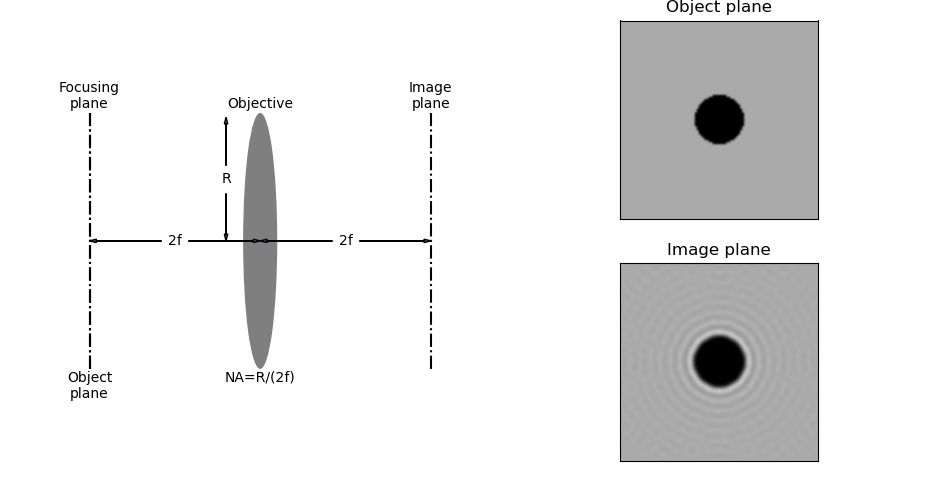

interactive(children=(FloatSlider(value=0.5, description='Objective NA:', layout=Layout(width='50%'), max=0.5,…

In [7]:
from imaging import *
from ipywidgets import interact, FloatSlider, Layout

%matplotlib notebook

imaging_setup = draw_imaging_setup(figsize=(9.5,5))
opts = {"style":{'description_width':'initial'},"layout":Layout(width='50%')}
slider1 = FloatSlider(description='Objective NA:', value=0.5, min=0, max=0.5, step=0.02, **opts)
slider2 = FloatSlider(description='Object plane shift:', value=0, min=-15, max=15, step=0.2, **opts)
interact(imaging_setup.update, NA=slider1, z_foc=slider2);